In [2]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from torch.nn import functional as F
import pickle
import gc

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
def split_df_into_subjects_dask(df):
    subject_names = df['Subject'].unique().compute()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df_dask(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values.compute()
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = da.split(subject_df.index.compute(), time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df_dask(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0].compute()
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [da.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]


# lets write a function that will plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = 1)
    # get the X and Y values for the event
    X = np.array([window[xcols].values for window in window_dfs])
    Y = np.array([window[ycols].values for window in window_dfs])
    # reshape the X and Y values for the model
    X = np.expand_dims(X, axis=0)
    X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
    Y = np.expand_dims(Y, axis=0)
    Y = Y.reshape(Y.shape[0], Y.shape[2], Y.shape[3])
    # get the prediction from the model
    Y_pred = model(torch.tensor(X, dtype=torch.float32).to(device))
    # get the prediction and actual values from the tensors
    Y_pred = Y_pred.detach().cpu().numpy()
    # knowing the stride we know that the prediction is every stride number of rows
    # lets make a list of indexs to keep track of which windows belond to which time points
    window_indices = [i.index for i in window_dfs]
    # go into each window indicies and append the predicitnos to each dataframe Fx_pred, Fy_pred, Fz_pred
    window_dfs = [window_dfs[i].assign(Fx_pred = Y_pred[0][i][0], Fy_pred = Y_pred[0][i][1], Fz_pred = Y_pred[0][i][2]) for i in range(len(window_dfs))]
    window_merged = pd.concat(window_dfs)
    # take the mean of each index using the window indices
    event_df = window_merged.groupby(window_merged.index).mean()
    return window_dfs

def batch_predict(model, input, batch_size=500):
    n_batches = int(np.ceil(input.shape[0] / batch_size))
    for i in range(n_batches):
        gc.collect()
        torch.cuda.empty_cache()
        if i == 0:
            output = model(input[i*batch_size:(i+1)*batch_size]).detach().cpu()
        else:
            output = torch.cat((output, model(input[i*batch_size:(i+1)*batch_size]).detach().cpu())).detach().cpu()
    return output

In [4]:
class Dataset_LSTM_Parallel(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = dd.from_pandas(df, npartitions=4)
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        self.sort_column = sort_column
        
        self.df = self.df.map_partitions(split_df_into_subjects, meta=(None,))
        self.df = self.df.map_partitions(split_subject_df, meta=(None,))
        self.df = self.df.map_partitions(lambda x: [sliding_event_df(event, window_size, stride) for event in x], meta=(None,))
        self.df = self.df.flatten()
        self.df = self.df.map(lambda x: x[xcols + ycols], meta=(None,))
        self.df = self.df.repartition(npartitions=4)
        
        self.X = da.stack([self.df[xcols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.X = self.X.reshape(-1, window_size, len(xcols))
        self.Y = da.stack([self.df[ycols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.Y = self.Y.reshape(-1, window_size, len(ycols))
        
        self.num_windows = self.X.shape[0]
        self.num_features = self.X.shape[2]
        self.num_outputs = self.Y.shape[2]
        
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        return self.X[idx].compute(), self.Y[idx].compute()
    
class lstm(nn.Module):
    def __init__(self, n_inputs=8, hidden_size=30, n_outputs=300, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.layer_size = layer_size
        self.n_linear_layers = n_linear_layers 
        self.lstm_n_outputs = lstm_n_outputs
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        rows = x.shape[0]
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        for i, fc in enumerate(self.fcs):
            if fc == self.fcs[0]:
                if x.shape[1] != int(fc.in_features):
                    try:    
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size)
                        x = F.relu(self.fcs[0](x))
                    except:
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size).to('cuda')
                        x = F.relu(self.fcs[0](x))
                else:
                    x = F.relu(fc(x))
            else:
                x = F.relu(fc(x))
        x = self.output(x)
        return x

In [5]:

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        # the window size represents how many samples to include in each window
        self.window_size = window_size
        # the stride represents how many samples to skip between windows
        self.stride = stride
        
        
        # make sure the df is ordered by subject
        self.df = self.df.sort_values(by=sort_column)
        self.df = self.df.reset_index(drop=True)
        self.subject_index = [i.values for i in self.df.groupby(sort_column).apply(lambda x: x.index)]
        self.subjects = list(self.df.groupby(sort_column).groups.keys())
        self.n_features = len(xcols)
        # sort the subject list index. self.subjects contains a list of indices for that belong to each subject. lets sort each list in ascending order
        # for each subject multiple trails are run. lets split them up and make a list of lists for each subject. The way we know a 
        # new event has started is when the time column resets to its minimum value.
        
        
        
        # split the subject index into events
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # reorganize the dataframe in the order of subject_events
        self.df = pd.concat([pd.concat([self.df.loc[subject] for subject in event]) for event in self.subject_events])
        self.df = self.df.reset_index(drop=True)
        
        
        # remake subjects_events to be consistent with the new dataframe
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # get rid of the empty lists in the list of lists
        self.subject_events = [[i for i in subject if len(i) > 0][0] for subject in self.subject_events]
        
        # for each subject we need to create a vector containig the indices for each window
        self.subject_windows = []
        for subject in self.subject_events:
            # get the number of windows for the subject
            n_windows = (len(subject) - self.window_size) // self.stride + 1
            # create a list of lists for the subject
            self.subject_windows.append([subject[i*self.stride:i*self.stride+self.window_size] for i in range(n_windows)])
        # get rid of the empty lists in the list of lists
        self.subject_windows = [[i for i in subject if len(i) > 0] for subject in self.subject_windows]
        # we should now be able to access the dataframe referencing the n-th frame of any subject using the __getitem__ method
        #self.subject_windows = np.concatenate(self.subject_windows)
        # reorganize self.subject_windows to be a single list of lists
        self.subject_windows = [i for subject in self.subject_windows for i in subject]
        # organize X for an LSTM model. The LSTM model expects the input to be in the shape (batch_size, seq_len, n_inputs)
        self.X = np.array([self.df.loc[window][self.xcols].values for window in self.subject_windows])
        self.X = self.X.reshape(-1, self.window_size, self.n_features)
        self.X = torch.from_numpy(self.X).float()
        
        # get the output
        self.Y = np.array([self.df.loc[window][self.ycols].values for window in self.subject_windows])
        self.Y  = torch.from_numpy(self.Y).float()
        self.Y = self.Y.view(self.X.shape[0], -1)
        self.X = self.X.to('cuda')
        self.Y = self.Y.to('cuda')
        return 
        
    
        
    def __getitem__(self, index):
        # the index is the index of the window in the subject_windows lis
        return self.df.loc[self.subject_windows[index]][self.xcols].values, self.df.loc[self.subject_windows[index]][self.ycols].values
    
    def __len__(self):
        return len(self.subject_index)

In [6]:
df = pd.read_pickle(r"C:\Users\efons\Desktop\kalyn_lstm\kmk\data\SeparatedData_MedFilt_v2-Copy1.pkl")
window_size = 100
stride = window_size
df

,Time,Event,EPB,EPL,FPL,APL,ADD,FCU,FPB,OPP,Fx,Fy,Fz,Subject
0,0.000000,0,0.298356,0.143422,0.271437,0.455853,0.445717,0.169887,0.216451,0.259434,-0.195990,-0.366495,-0.011809,bXa12
1,0.024631,0,0.394776,0.201529,0.336203,0.588685,0.542767,0.169887,0.220666,0.327056,-0.187540,-0.370361,-0.048656,bXa12
2,0.049261,0,0.437829,0.262160,0.397237,0.693981,0.636553,0.169887,0.226120,0.391021,-0.176207,-0.398903,0.002597,bXa12
3,0.073892,0,0.440273,0.321387,0.423438,0.696560,0.717565,0.169887,0.232679,0.447697,-0.189739,-0.391285,-0.003678,bXa12
4,0.098522,0,0.444903,0.375241,0.424493,0.702552,0.719058,0.169887,0.239881,0.494490,-0.185666,-0.356704,-0.019328,bXa12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,4.901151,2,0.258348,0.599492,0.991095,0.845696,0.750183,0.397436,0.701687,0.778256,-11.387135,-67.483305,-3.131550,zNu44
608,4.925780,2,0.255153,0.599492,0.991095,0.845696,0.750183,0.404779,0.701687,0.778256,-11.355251,-67.445019,-3.110487,zNu44
609,4.950409,2,0.251757,0.599492,0.991095,0.845696,0.742197,0.411974,0.701687,0.778256,-11.363783,-67.451038,-3.034538,zNu44
610,4.975038,2,0.248169,0.599492,0.991095,0.845696,0.731769,0.418274,0.701687,0.778256,-11.271886,-67.532919,-3.076844,zNu44


In [7]:
leave_out_df = df[df['Subject'] == 'RGr10']
train_df = df[df['Subject'] != 'RGr10']
train_data = Dataset_LSTM(train_df, window_size=window_size, stride=stride)
test_data = Dataset_LSTM(leave_out_df, window_size=window_size, stride=stride)

In [8]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=8).to('cuda')
model(train_data.X[0:10].to('cuda')).shape
model.load_state_dict(torch.load('.\models\lstm_3layer_30nodes_200epochs_2023-02-18.pt'))

<All keys matched successfully>

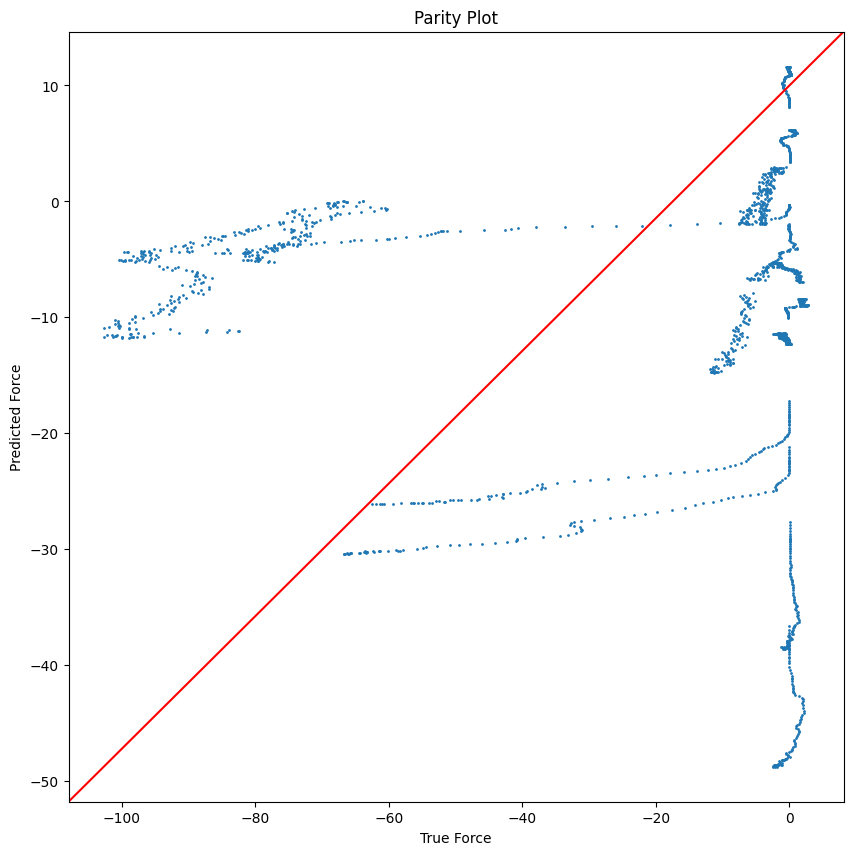

In [9]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
pred = batch_predict(model, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [10]:
def TLLSTM(model, X, change_layers=1):
    new = lstm(n_linear_layers=model.n_linear_layers, n_outputs=model.output.out_features, lstm_n_outputs=model.lstm_n_outputs, layer_size=model.layer_size)
    test = new(X)
    new.load_state_dict(model.state_dict())
    children = [child for child in new.children()]
    for child in children:
        for param in child.parameters():
            param.requires_grad = False
    total_layers = len(children)
    for i in range(change_layers):
        layer = children[total_layers-i-1]
        layer_params = layer.parameters()
        for p in layer_params:
            p.requires_grad = True
    return new

# makes make another TLMLSTM_newlayers function
def TLMLSTM_newlayers(model, X, change_layers=1, new_layer_size=10):
    new = lstm(n_linear_layers=model.n_linear_layers, 
               n_outputs=model.output.out_features, 
               lstm_n_outputs=model.lstm_n_outputs, 
               layer_size=model.layer_size)
    test = new(X)
    new.load_state_dict(model.state_dict())
    children = [child for child in new.children()]
    for child in children:
        for param in child.parameters():
            param.requires_grad = False
    total_layers = len(children)
    # add the new layers
    new.new_layer_size = new_layer_size
    new.layers = len(new.fcs) + change_layers
    for i in range(change_layers):
        if i == 0:
            new.fcs.append(nn.Linear(new.layer_size, new.new_layer_size))
        else:
            new.fcs.append(nn.Linear(new.new_layer_size, new.new_layer_size))
            # make sure the new layers are trainable
        new.fcs[-1].requires_grad = True
    # make the new output layer 
    new.output = nn.Linear(new.new_layer_size, new.output.out_features)
    return new

In [12]:
# okay so the kmk.run_Pytorch function returns the loss of the model. and model 
# is now trained. Lets use this to create a random search for the LSTM hyperparameters.
# the hyperparameters we will be searching for are the number of layers, the number of nodes in each layer
# and batch_size
# the random_models_LSTM function will take inputs of the ranges of the hyperparameters, generate n_iter random models with those hyperparameters. 
# the random_search function will take the random_models_LSTM function and the run_Pytorch function and run the random search
# and return the best model and the best loss, and all the models trained and their losses. A dictionary 
# of the hyperparameters and the loss will also be returned.
# !-----------------
# reference lstm model params
# !-------
# lstm hidden_size=30, n_outputs=300, n_linear_layers=1, 
#                 layer_size=10, lstm_n_outputs=30)
# ! ----------------
def random_models_LSTM(n_iter, lstm_hidden_size_range=[10, 100], n_linear_layers_range=[1, 5], 
                       layer_size_range=[10, 100], lstm_n_outputs_range=[10, 100], batch_size_range=[10, 100], learning_rate_range=[0.0001, 0.1]):
    # create a dataframe to store the models
    models = pd.DataFrame(columns=['lstm_hidden_size', 'n_linear_layers', 'layer_size', 'lstm_n_outputs'])
    # loop through the number of models
    for i in range(n_iter):
        # get the hyperparameters
        lstm_hidden_size = np.random.randint(lstm_hidden_size_range[0], lstm_hidden_size_range[1])
        n_linear_layers = np.random.randint(n_linear_layers_range[0], n_linear_layers_range[1])
        layer_size = np.random.randint(layer_size_range[0], layer_size_range[1])
        lstm_n_outputs = np.random.randint(lstm_n_outputs_range[0], lstm_n_outputs_range[1])
        batch_size = np.random.randint(batch_size_range[0], batch_size_range[1])
        learning_rate = np.random.uniform(learning_rate_range[0], learning_rate_range[1])
        # store the hyperparameters
        models.loc[i, 'lstm_hidden_size'] = lstm_hidden_size
        models.loc[i, 'n_linear_layers'] = n_linear_layers
        models.loc[i, 'layer_size'] = layer_size
        models.loc[i, 'lstm_n_outputs'] = lstm_n_outputs
        models.loc[i, 'batch_size'] = batch_size
        models.loc[i, 'learning_rate'] = learning_rate
    return models



# use random_models_LSTM to generate the models
# use run_Pytorch to train the models
# return the best model and the best loss, and all the models trained and their losses. A dataframe
# of the hyperparameters and the loss will also be returned. store the model on the df as well. 
def train_LSTMs(models, train_data, test_data, n_epochs=100, learning_rate=None):
    # create a dataframe to store the losses
    losses = pd.DataFrame(columns=['loss'])
    # loop through the models
    for i in range(len(models)):
        # get the hyperparameters
        lstm_hidden_size = models.loc[i, 'lstm_hidden_size']
        n_linear_layers = models.loc[i, 'n_linear_layers']
        layer_size = models.loc[i, 'layer_size']
        lstm_n_outputs = models.loc[i, 'lstm_n_outputs']
        batch_size = models.loc[i, 'batch_size']
        if learning_rate is None:
            learning_rate = models.loc[i, 'learning_rate']
        else:
            pass
        # create the model
        model = lstm(n_linear_layers=n_linear_layers,lstm_n_outputs=lstm_n_outputs, layer_size=layer_size, n_outputs=train_data.Y.shape[1], hidden_size=lstm_hidden_size)
        model = model.to('cuda')
        print(model(train_data.X[0].to('cuda')))
        print(model)
        # train the model
        print('training model', i)
        print('batch_size', batch_size)
        # print the how many observations are in the training data
        print('training data size', len(train_data.X))
        print('testing data size', len(test_data.X))
        print('shape of training data', train_data.X.shape, train_data.Y.shape)
        print('shape of testing data', test_data.X.shape, test_data.Y.shape)
              
        loss = kmk.run_Pytorch(model, train_data.X, train_data.Y, batch_size=models.loc[i, 'batch_size'], 
                               learning_rate=models.loc[i, 'learning_rate'], n_epochs=n_epochs, device='cuda')
        # store the loss
        pred = model(test_data.X.to('cuda')).detach().cpu().numpy()
        mae = mean_absolute_error(test_data.Y.detach().cpu().numpy(), pred)
        r2 = r2_score(test_data.Y.detach().cpu().numpy(), pred)
        mse = mean_squared_error(test_data.Y.detach().cpu().numpy(), pred)
        losses.loc[i, 'mae'] = mae
        losses.loc[i, 'r2'] = r2
        losses.loc[i, 'mse'] = mse
        # store the model
        models.loc[i, 'model'] = model
    # get the best model and loss
    # best_loss = losses['loss'].min()
    # best_model = models.loc[losses['loss'].idxmin(), 'model']
    # TypeError: reduction operation 'argmin' not allowed for this dtype
    # try again
    # use the last index in each loss list
    best_score = losses['r2'].max()
    best_model = models.loc[losses['mae'].idxmin(), 'model']
    return best_model, best_score, models, losses, models

    
# test with 2 models and 10 datapoints
x_test = torch.rand(10, 1)
y_test = torch.rand(10, 1)

models = random_models_LSTM(20, batch_size_range=[2, len(train_data.X-1)], lstm_hidden_size_range=[5, 50], n_linear_layers_range=[1, 4],
                          layer_size_range=[5, 50], lstm_n_outputs_range=[1, 50])
best_model, best_loss, models, losses, models = train_LSTMs(models, train_data, test_data, learning_rate=1e-3, n_epochs=401)

tensor([[ 0.0873, -0.0280,  0.0579,  ..., -0.0947,  0.0279,  0.0809],
        [ 0.0798, -0.0322,  0.0478,  ..., -0.1025,  0.0333,  0.0801],
        [ 0.0758, -0.0346,  0.0438,  ..., -0.1038,  0.0374,  0.0814],
        ...,
        [ 0.0728, -0.0367,  0.0406,  ..., -0.1027,  0.0445,  0.0908],
        [ 0.0728, -0.0367,  0.0406,  ..., -0.1027,  0.0445,  0.0909],
        [ 0.0728, -0.0367,  0.0406,  ..., -0.1027,  0.0445,  0.0909]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
lstm(
  (lstm): LSTM(8, 5, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=5, out_features=46, bias=True)
    (1): Linear(in_features=46, out_features=46, bias=True)
  )
  (output): Linear(in_features=46, out_features=300, bias=True)
)
training model 0
batch_size 26.0
training data size 42
testing data size 6
shape of training data torch.Size([42, 100, 8]) torch.Size([42, 300])
shape of testing data torch.Size([6, 100, 8]) torch.Size([6, 300])
EPOCH :  0 , dt:  0.17144775390625 seconds, losse

(   loss        mae        r2         mse
 0   NaN  12.527972  0.235792  296.890472
 1   NaN  14.083491  0.057239  371.900391
 2   NaN  15.469049  0.097844  411.698181
 3   NaN  12.384174  0.195795  299.401947
 4   NaN  11.129784  0.321909  243.653381
 5   NaN   9.937496  0.383752  212.650497
 6   NaN  10.995172  0.292203  268.024384
 7   NaN  16.475801 -0.012281  457.296265
 8   NaN  12.525088  0.199163  318.750000
 9   NaN  11.721553  0.295129  270.000366
 10  NaN  10.579892  0.287526  230.664169
 11  NaN  10.178592  0.309678  195.050705
 12  NaN  12.830351  0.429211  308.350586
 13  NaN  11.548222  0.265932  267.126495
 14  NaN   8.156756  0.535072  134.306900
 15  NaN  11.072762  0.344491  239.439865
 16  NaN  14.233348  0.044100  356.954071
 17  NaN  11.074922  0.310099  267.542542
 18  NaN  16.169180  0.042238  456.257599
 19  NaN  13.254181  0.082552  367.640717,
 lstm(
   (lstm): LSTM(8, 30, batch_first=True)
   (fcs): ModuleList(
     (0): Linear(in_features=3000, out_features

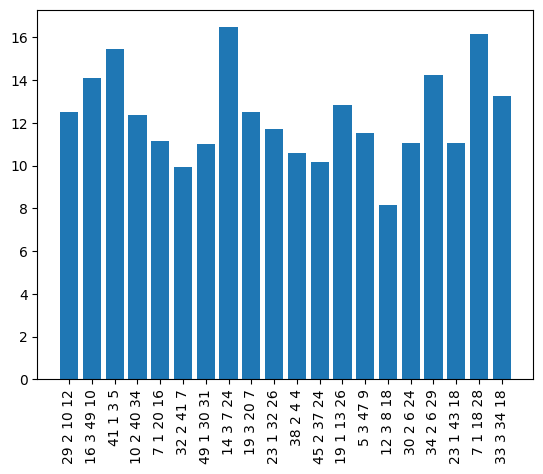

In [16]:
# plot the losses of the best model
plt.bar(losses.index, losses['mae'])
# label the x axis with the model attributes 
model_architecture = []
for model in models.index:
    model_architecture.append(str(models.loc[model, 'lstm_hidden_size']) + ' ' + str(models.loc[model, 'n_linear_layers']) + ' ' + str(models.loc[model, 'layer_size']) + ' ' + str(models.loc[model, 'lstm_n_outputs']))
plt.xticks(losses.index, model_architecture, rotation=90)

losses, best_model

In [17]:
best_model_index = losses['mae'].idxmin()
best_model = models.loc[best_model_index, 'model']
best_model_hyperparameters = models.loc[best_model_index]
best_model_hyperparameters

lstm_hidden_size                                                   12
n_linear_layers                                                     3
layer_size                                                          8
lstm_n_outputs                                                     18
batch_size                                                       19.0
learning_rate                                                0.062259
model               lstm(\n  (lstm): LSTM(8, 30, batch_first=True)...
Name: 14, dtype: object

In [22]:
new = TLMLSTM_newlayers(model.to('cpu'), 
                        train_data.X[0:10].to('cpu'), 
                        change_layers=5, new_layer_size=5)
new(train_data.X[0:10].to('cpu'))
new = new.to('cuda')

In [ ]:
new

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3000, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=5, bias=True)
    (6): Linear(in_features=5, out_features=5, bias=True)
    (7): Linear(in_features=5, out_features=5, bias=True)
  )
  (output): Linear(in_features=5, out_features=300, bias=True)
)

In [61]:

tlm = TLLSTM(model, train_data.X[0:10].to('cpu'), change_layers=3)

In [62]:
X_train = train_data.X.to('cuda')
Y_train = train_data.Y.to('cuda')
X_test = test_data.X.to('cuda')
Y_test = test_data.Y.to('cuda')

In [63]:
lr = 1e-3
new = tlm
batch_size = 4
beta = 0.001
n_epochs = 2000
new = tlm
loss = kmk.run_Pytorch(new, X_train, Y_train, n_epochs=n_epochs, learning_rate=lr, batch_size=batch_size,
                       optimizer=torch.optim.Adam(new.parameters(), lr=lr, weight_decay=beta))

EPOCH :  0 , dt:  0.26424217224121094 seconds, losses : 2282.135009765625
EPOCH :  10 , dt:  2.481292486190796 seconds, losses : 2077.724609375
EPOCH :  20 , dt:  2.4883980751037598 seconds, losses : 1212.390869140625
EPOCH :  30 , dt:  2.369004487991333 seconds, losses : 703.88037109375
EPOCH :  40 , dt:  2.345433235168457 seconds, losses : 288.4584045410156
EPOCH :  50 , dt:  2.253190040588379 seconds, losses : 223.7393341064453
EPOCH :  60 , dt:  2.2397470474243164 seconds, losses : 209.77272033691406
EPOCH :  70 , dt:  2.2526307106018066 seconds, losses : 202.26161193847656
EPOCH :  80 , dt:  2.2296721935272217 seconds, losses : 196.8497772216797
EPOCH :  90 , dt:  2.1908071041107178 seconds, losses : 193.0694580078125
EPOCH :  100 , dt:  2.210584878921509 seconds, losses : 189.0426025390625
EPOCH :  110 , dt:  2.301138162612915 seconds, losses : 186.54818725585938
EPOCH :  120 , dt:  2.196091651916504 seconds, losses : 184.8153839111328
EPOCH :  130 , dt:  2.2548913955688477 secon

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Learning Curve'}, xlabel='Epoch', ylabel='Loss'>)

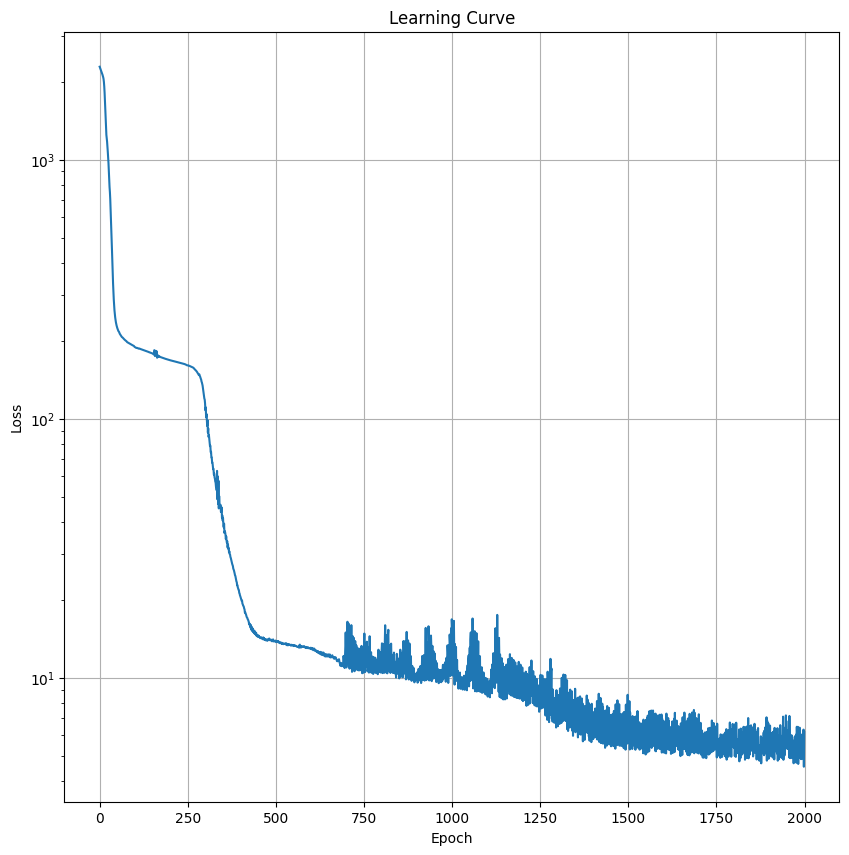

In [66]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way. Make the y axis
# log scale. 
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale('log')
    # add a grid
    ax.grid()
    return fig, ax
plot_learning_curve(loss, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

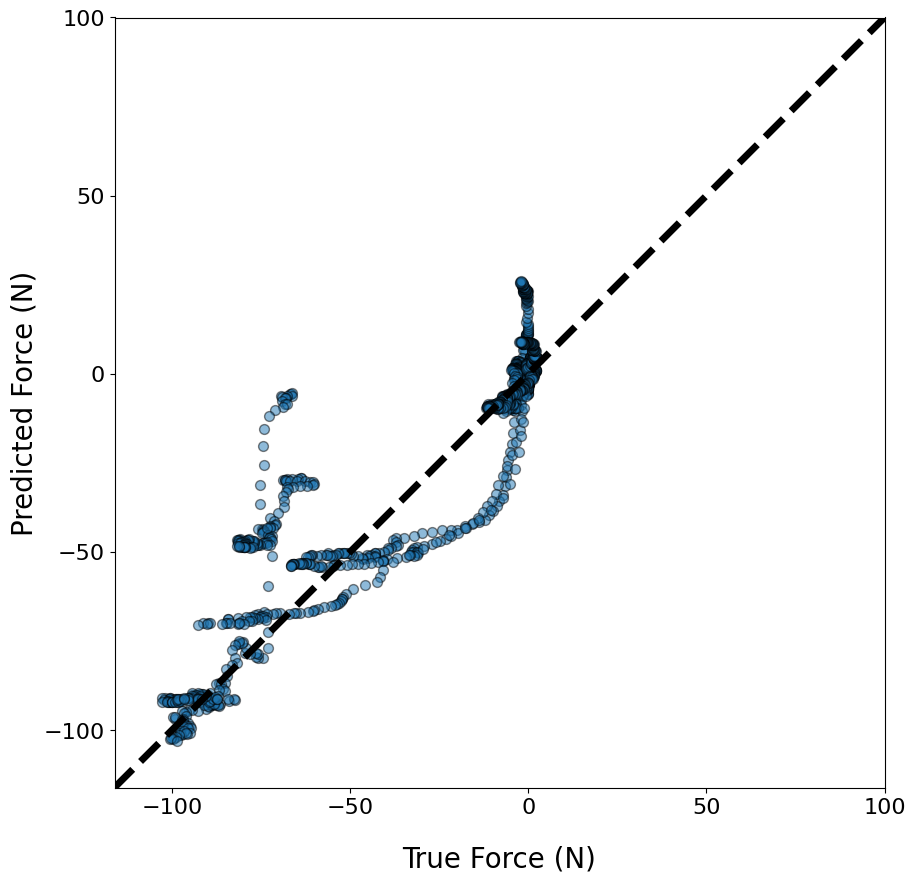

In [67]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
tlm = new
pred = batch_predict(tlm, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=50, alpha=0.5, edgecolors='k')
# make equal aspect on the axes
ax.set_aspect('equal')
# the axes should be the same range as well. get the largest range and set the axes to that
max_range = np.array([test_data.Y.flatten().detach().cpu().numpy().max(), pred.flatten().max()]).max()
# get min_range
min_range = np.array([test_data.Y.flatten().detach().cpu().numpy().min(), pred.flatten().min()]).min()
# set the axes to the max range. Add a little padding using 10% of the range
x_range = max_range - min_range
ax.set_xlim([min_range - x_range*0.1, max_range + x_range*0.1])
ax.set_ylim([min_range - x_range*0.1, max_range + x_range*0.1])

#ax.set_xlabel('True Force', fontsize=20)
#ax.set_ylabel('Predicted Force', fontsize=20)
#ax.set_title('Parity Plot', fontsize=30) 
ax.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax.transAxes)
ax.set_xlabel('True Force (N)', fontsize = 20)
ax.set_ylabel('Predicted Force (N)', fontsize = 20)
ax.set_xticks([-100, -50, 0, 50, 100])
ax.set_yticks([-100, -50, 0, 50, 100])
ax.tick_params(axis='both', which = 'major', labelsize = 16)
ax.xaxis.labelpad=20
# increase the padding between the title and the plot
#ax.title.set_position([.5, 1.05])
#ax.set_title('Parity Plot', fontsize=30)
plt.savefig('parity_plot.png', dpi=600)

In [70]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mae = mean_absolute_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mse = mean_squared_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.8597022185136177 mae:  7.230763 mse:  156.72882


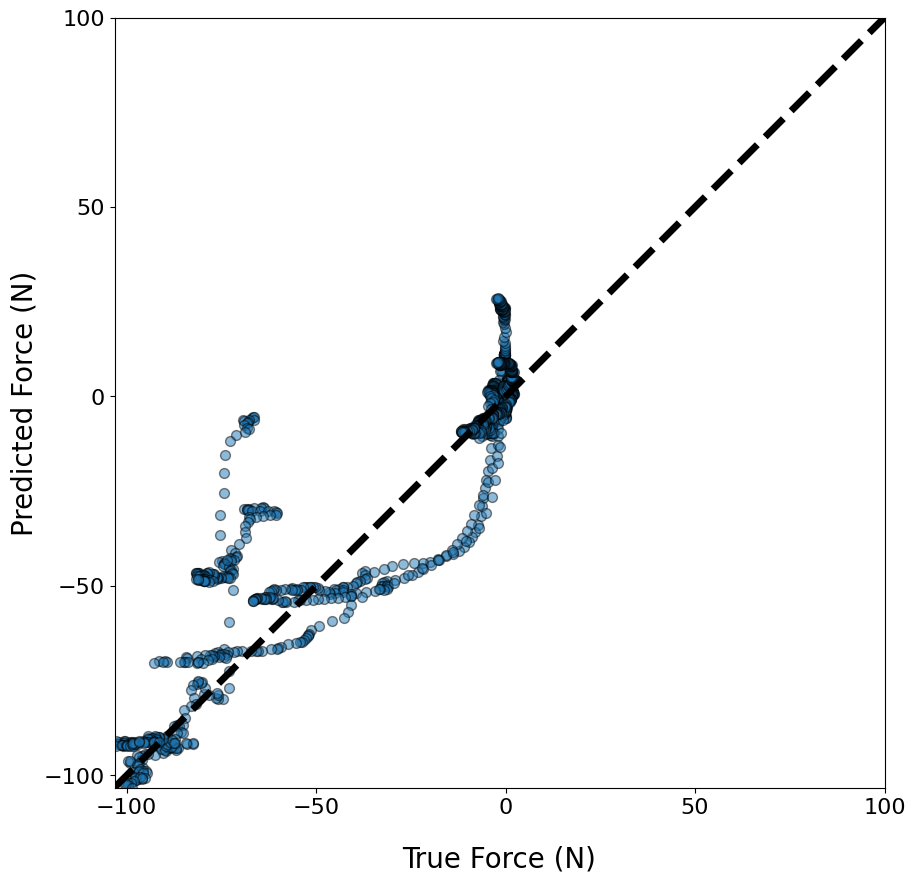

In [71]:
# KALYN's Plot
# test the model on the test data. I dont expect this to work well because the model was only on simulated data

# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=50, alpha=0.5, edgecolors='k')
# make equal aspect on the axes
ax.set_aspect('equal')
# the axes should be the same range as well. get the largest range and set the axes to that
max_range = np.array([test_data.Y.flatten().detach().cpu().numpy().max(), pred.flatten().max()]).max()
# get min_range
min_range = np.array([test_data.Y.flatten().detach().cpu().numpy().min(), pred.flatten().min()]).min()
# set the axes to the max range
ax.set_xlim(min_range, max_range)
ax.set_ylim(min_range, max_range)
#ax.set_xlabel('True Force', fontsize=20)
#ax.set_ylabel('Predicted Force', fontsize=20)
#ax.set_title('Parity Plot', fontsize=30) 
ax.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax.transAxes)

ax.set_xlabel('True Force (N)', fontsize = 20)
ax.set_ylabel('Predicted Force (N)', fontsize = 20)
ax.set_xticks([-100, -50, 0, 50, 100])
ax.set_yticks([-100, -50, 0, 50, 100])
ax.tick_params(axis='both', which = 'major', labelsize = 16)
ax.xaxis.labelpad=20

plt.savefig('LSTM_TL_ExpTest.png', dpi = 600)

In [50]:
from datetime import datetime
import os
def save_model(model, name):
    # check if models folder exists
    if not os.path.exists('models'):
        os.mkdir('models')
    # check if the model already exists and add a number to the end
    if os.path.exists('models/' + name + '.pt'):
        i = 0
        while os.path.exists('models/' + name + str(i) + '.pt'):
            i += 1
        torch.save(model.state_dict(), 'models/' + name + str(i) + '.pt')
    torch.save(model.state_dict(), 'models/' + name + '.pt')
# save the model include the todays date
save_model(model, 'tlm_lstm_3layer_30nodes_200epochs_' + str(datetime.now().date()))

In [ ]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model(train_data.X[0:10].to('cuda')).shape
model.load_state_dict(torch.load('.\models\lstm_3layer_30nodes_200epochs_2023-02-08.pt'))
tlm = TLLSTM(model, train_data.X[0:10].to('cpu'), change_layers=3)
tlm.load_state_dict(torch.load(r"C:\Users\efons\Desktop\kalyn_lstm\kmk\notebooks\models\tlm_lstm_3layer_30nodes_200epochs_2023-02-082.pt"))
tlm = tlm.to('cuda')

42
(100, 3)
[ -0.86976606 -54.070576    -7.649217  ]


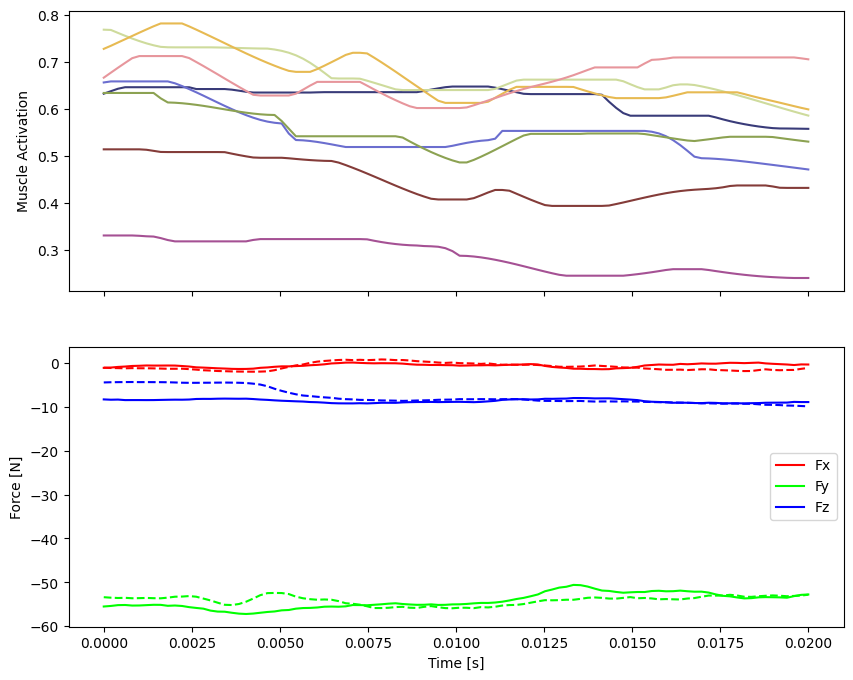

In [81]:
# plot a sample of the data

# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]

n = np.random.randint(0, len(train_data.X))
print(len(train_data.X))
x_plot = torch.from_numpy(train_data.X[n].cpu().numpy()).float().detach().cpu().numpy()
y_plot = train_data.Y[n].float().detach().cpu().numpy().reshape(-1, 3)
time = np.linspace(0, 2/window_size, len(x_plot))
print(y_plot.shape)
y_labels = train_data.ycols
x_labels = train_data.xcols
# lets remake this plot but make the two subplots share the x axis
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)  
# make sure the colors for xplot do not overlap with yplot. Make xplot from the viridis colormap. there are 8 columns in xplot
for i in range(x_plot.shape[1]):
    ax[0].plot(time, x_plot[:,i], color=plt.cm.tab20b(i/x_plot.shape[1]))
ax[0].set_ylabel('Muscle Activation')    
# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]
for i in range(y_plot.shape[1]):
    ax[1].plot(time, y_plot[:,i], color=line_colors[i])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Force [N]')
ax[1].legend(y_labels)
#plot the prediction of this sample 
pred = tlm(train_data.X[n].float().to('cuda').unsqueeze(0)).detach().cpu().numpy().reshape(-1, 3)
for i in range(pred.shape[1]):
    ax[1].plot(time, pred[:,i], color=line_colors[i], linestyle='--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

In [1]:
# plot all the test data and the predictions
# for each value of X predict Y and append it all together then plot
pred = []
line_colors = [(1,0,0), (0,1,0), (0,0,1)]
for i in range(len(test_data.X)):
    pred.append(tlm(test_data.X[i].float().to('cuda').unsqueeze(0)).detach().cpu().numpy())
pred = np.abs(np.array(pred).reshape(-1, 3))
# plot the predictions
fig, ax = plt.subplots(2, 1, figsize=(10,8))
time = np.linspace(test_data.df['Time'].min(), test_data.df['Time'].max(), len(pred))
y = np.abs(test_data.Y.detach().cpu().numpy().reshape(-1, 3))
x = test_data.X.detach().cpu().numpy().reshape(-1, 8)
# plot the X in the top pane
for i in range(x.shape[1]):
    ax[0].plot(time, x[:,i], color=plt.cm.tab20b(i/x.shape[1]))
ax[0].set_ylabel('Muscle Activation', fontsize=20)
# plot the predictions
for i in range(pred.shape[1]):
    ax[1].plot(time, pred[:,i], color=line_colors[i], linestyle='--')
# plot the true values
for i in range(y.shape[1]):
    ax[1].plot(time, y[:,i], color=line_colors[i])
ax[1].set_ylabel('Force [N]', fontsize=20)
ax[1].set_xlabel('Time [s]', fontsize=20)
# make ax[0] and ax[1] share the x axis
ax[0].get_shared_x_axes().join(ax[0], ax[1])
# remove the x ticks from ax[0]
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')

NameError: name 'test_data' is not defined

6
(100, 3)
[  1.8208369 -42.696667   -3.7069237]


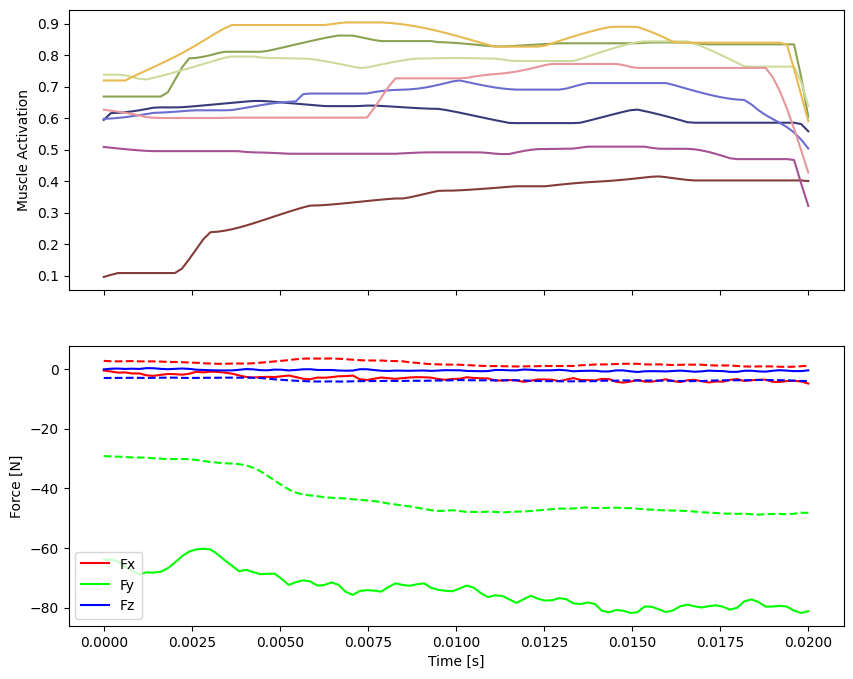

In [88]:
# plot a sample of the data

# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]

n = np.random.randint(0, len(test_data.X))
print(len(test_data.X))
x_plot = torch.from_numpy(test_data.X[n].cpu().numpy()).float().detach().cpu().numpy()
y_plot = test_data.Y[n].float().detach().cpu().numpy().reshape(-1, 3)
time = np.linspace(0, 2/window_size, len(x_plot))
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols
# lets remake this plot but make the two subplots share the x axis
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)  
# make sure the colors for xplot do not overlap with yplot. Make xplot from the viridis colormap. there are 8 columns in xplot
for i in range(x_plot.shape[1]):
    ax[0].plot(time, x_plot[:,i], color=plt.cm.tab20b(i/x_plot.shape[1]))
ax[0].set_ylabel('Muscle Activation')    
# line_colors = red, green, blue
line_colors = [(1,0,0), (0,1,0), (0,0,1)]
for i in range(y_plot.shape[1]):
    ax[1].plot(time, y_plot[:,i], color=line_colors[i])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Force [N]')
ax[1].legend(y_labels)
#plot the prediction of this sample 
pred = new(test_data.X[n].float().to('cuda').unsqueeze(0)).detach().cpu().numpy().reshape(-1, 3)
for i in range(pred.shape[1]):
    ax[1].plot(time, pred[:,i], color=line_colors[i], linestyle='--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

In [ ]:
# lets make another transfer learning model that will freeze the weights of all the layers and 
# add a new layer at the end that will be trained

def TLLSTM_newlayers(
    new = lstm(model.
    # freeze the weights of the model
    for param in model.parameters():
        param.requires_grad = False
    # remove the old output layer
    model.ouptut = None
    model.fcs.append()

# now with weight_decay

In [ ]:
tlm = TLLSTM(model, train_data.X[0:10].to('cpu'), change_layers=2)
loss = kmk.run_Pytorch(tlm, X_train, Y_train, n_epochs=501, learning_rate=1e-3, batch_size=16, optimizer=torch.optim.Adam(tlm.parameters(), lr=1e-3, weight_decay=1e-1))

In [ ]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, len(losses))
    ax.set_ylim(0, max(losses))
    ax.grid()
    return fig, ax
plot_learning_curve(loss, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

In [ ]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
pred = batch_predict(tlm, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mae = mean_absolute_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mse = mean_squared_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


In [ ]:
# retrain the whole model
from copy import copy
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model(train_data.X[0:10].to('cuda')).shape
model.load_state_dict(torch.load('.\models\lstm_3layer_30nodes_200epochs_2023-02-08.pt'))
model_retrain = copy(model)
model_retrain.to('cuda')
loss = kmk.run_Pytorch(model_retrain, X_train, Y_train, n_epochs=501, learning_rate=1e-3, batch_size=16)#, optimizer=torch.optim.Adam(model_retrain.parameters(), lr=1e-3, weight_decay=1e-1))

In [ ]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, len(losses))
    ax.set_ylim(0, max(losses))
    ax.grid()
    return fig, ax
plot_learning_curve(loss, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

In [ ]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
pred = batch_predict(tlm, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mae = mean_absolute_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mse = mean_squared_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)
